# Integrations Seminar Project

### Import neccessary libraries

In [1]:
import requests
import random
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime
import time as t

    Initialization of the Dataframe with columns for scrapable data

In [15]:
data = {'Bewohner': [], 'Eintrag': [], 'Miete': [], 'Groese': [] , 'Stadtteil': [], 'frei ab': [], 'frei bis': []}
df = pd.DataFrame(data=data)

Empty DataFrame
Columns: [Bewohner, Eintrag, Miete, Groese, Stadtteil, frei ab, frei bis]
Index: [] 0


# 1. Setup Web-Scraper
    Setup of proxie and user-agent caroussel. These will be rotated between requests to avoid bot-detection

In [16]:
proxies = [
    'http://24.106.221.230:53281',
    'http://118.70.12.171:53281',
    'http://198.199.86.11:8080',
    'http://107.173.80.140:9000',
    'http://159.203.61.169:8080',
    'http://134.209.29.120:3128',
    'http://192.140.42.83:31511',
    'http://20.187.77.5:80',
    'http://64.225.8.191:9986',
    'http://198.59.191.234:8080',
    'http://51.178.47.12:80',
    'http://82.180.163.163:80',
    'http://158.69.72.138:9300',
    'http://198.49.68.80:80',
    'http://51.15.192.229:8080',
    'http://161.35.70.249:8080',
    'http://143.110.232.177:80',
    'http://154.118.228.212:80',
    'http://177.87.144.122:5566',
    'http://200.25.254.193:54240',
    'http://82.180.163.163:80'
    ]

userAgents = [
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.1 Safari/605.1.15',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:77.0) Gecko/20100101 Firefox/77.0',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
]

    Request and scrape functions

    makeRequest: takes URL and makes request using randomly picked proxy and user-agent
    scrapeTable: takes in the tbody element of the page, extracts datapoints through getters and adds data to the dataframe

In [17]:
def makeRequest(url):
    try:
        randomNum = random.randint(0, len(proxies) - 1)
        proxy = {proxies[randomNum][0 : 4] : proxies[randomNum]} # dict {http/s : IP-Address}
        userAgent = userAgents[random.randint(0, len(userAgents) -1)]
        #print('Current Proxy: ', proxy, 'Current User-Agent: ', userAgent)
        
        return requests.get(url,
                            proxies=proxy,
                            headers={'User-Agent' : userAgent},
                            timeout=5)
    except:
        print("PROBLEM WHILE MAKING REQUEST")

def scrapeTable(tbody) -> None:
    data = []
    rows = tbody.findAll('tr')
    for row in rows:
        data.append(getFlatmates(row))
        data.append(getDatePosted(row))
        data.append(getPrice(row))
        data.append(getRoomSize(row))
        data.append(getNeighborhood(row))
        data.append(getMoveInDate(row))
        data.append(getMoveOutDate(row))
        
        df.loc[len(df)] = data
        data.clear()
    
def getFlatmates(row):
    flatMatesDict = row.findAll('td')[1].span.attrs
    return flatMatesDict.get('title')

def getDatePosted(row):
    return row.findAll('td')[2].span.text.strip()

def getPrice(row):
    return row.findAll('td')[3].b.text.strip()

def getRoomSize(row):
    return row.findAll('td')[4].span.text.strip()

def getNeighborhood(row):
    return  row.findAll('td')[5].span.text

def getMoveInDate(row):
    return  row.findAll('td')[6].span.text.strip()

def getMoveOutDate(row):
    date = row.findAll('td')[7].a
    if date.find('span'):
        return date.find('span').text.strip()
    
    return ""

# 2. Data Collection
    Loop through wg-gesucht pagination and scrape the tbody element on each page

In [ ]:
for i in range(436, 500):
    print(f'Page: {i}', end=' ')
    res = makeRequest(f'https://www.wg-gesucht.de/wg-zimmer-in-Mannheim.85.0.0.{i}.html')
    try: 
        page = BeautifulSoup(res.content, 'html.parser')
        scrapeTable(page.findAll('tbody')[0])
    except Exception as ex:
        print(ex)
        print(page.prettify())
        break

    t.sleep(random.randint(0,20))

In [91]:
df.to_excel('raw_data.xlsx')

In [94]:
df = df.drop(df[df.Groese == 'n.a.'].index)
df = df.drop(df[df.Bewohner == ''].index)
df.Miete = df.Miete.map(lambda x: int(x[0:len(x)-1]) if type(x) == str else x)
df = df.drop(df[df.Miete > 1000].index)


In [95]:
len(df)

9976

# 3. Clean & Process

In [97]:
rentPrice = df['Miete'].tolist()
roomSize = df['Groese'].tolist()
flatmates = df['Bewohner'].tolist()

for i, room in enumerate(roomSize):
    roomSize[i] = int(room[0: len(room) - 2])

for i, flat in enumerate(flatmates):
    endIndex = flat.find('er')
    if type(flat[0:endIndex]) == str:
        flatmates[i] = int(flat[0:endIndex])

moveInDates = []
for i, date in enumerate(df['frei ab'].tolist()):
    if date !='aktuell' and date != '':
        moveInDates.append(datetime.strptime(date, "%d.%m.%Y").date())
    else: 
        moveInDates.append(datetime.today().date())

males = []
females = []

malePercentage = []
femalePercentage = []
for i, el in enumerate(df['Bewohner'].tolist()):
    begin = el.find('(') + 1
    end = el.find(')')
    inhabitants = el[begin : end]

    femInhabitants = int(inhabitants[0: inhabitants.find('w')])
    maleInhabitants = int(inhabitants[inhabitants.find('w') + 2: inhabitants.find('m')])

    femPercent = femInhabitants / flatmates[i] # (maleInhabitants + femInhabitants) if maleInhabitants + femInhabitants != 0 else 1.0 # flatmates[i]
    malePercent = maleInhabitants / flatmates[i] # (maleInhabitants + femInhabitants) if maleInhabitants + femInhabitants != 0 else 1.0     # flatmates[i]

    males.append(maleInhabitants)
    females.append(femInhabitants)
    malePercentage.append(malePercent)
    femalePercentage.append(femPercent)

In [98]:
timeToMoveIn = []
for i, date in enumerate(moveInDates):
    time = (date - datetime.today().date()).days if (date - datetime.today().date()).days >= 0 else 0
    timeToMoveIn.append(time)

In [99]:
df_copy = df.copy()

    Add cleaned data into new dataframe columns

In [100]:
df_copy['flatmates'] = flatmates
df_copy['time to move in'] = timeToMoveIn
df_copy['Male Inhabitants'] = males
df_copy['Female Inhabitants'] = females
df_copy['% Male Flatmates'] = malePercentage
df_copy['% Female Flatmates'] = femalePercentage


    export dataframe as excel sheet

In [101]:
df_copy.to_excel('wg_mannheim_cleaned.xlsx')

# 4. Analyse & Visualize

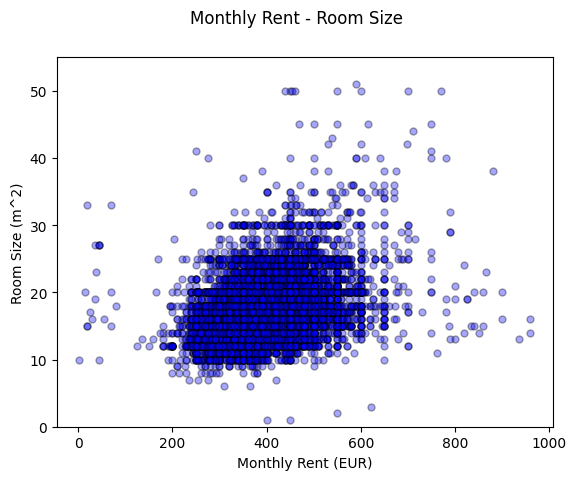

PearsonRResult(statistic=0.23822406389586734, pvalue=9.707137134293657e-129)

In [102]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.suptitle("Monthly Rent - Room Size")
plt.ylim(0,55)
plt.xlabel('Monthly Rent (EUR)')
plt.ylabel('Room Size (m^2)')

plt.scatter(rentPrice, roomSize, s=25, c='blue',edgecolors='black', linewidths=1, alpha=0.35)
plt.show()

stats.pearsonr(rentPrice, roomSize)


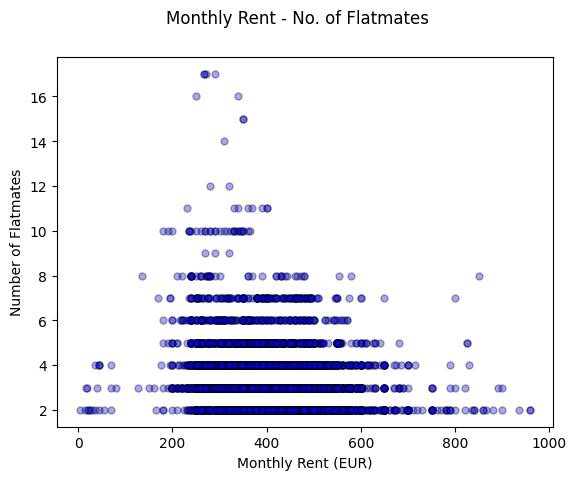

PearsonRResult(statistic=-0.179733169784917, pvalue=3.362539221650267e-73)

In [103]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.suptitle("Monthly Rent - No. of Flatmates")
plt.xlabel('Monthly Rent (EUR)')
plt.ylabel('Number of Flatmates')

plt.scatter(rentPrice, flatmates, s=25, c='blue',edgecolors='black', linewidths=1, alpha=0.35)
plt.show()

stats.pearsonr(rentPrice, flatmates)

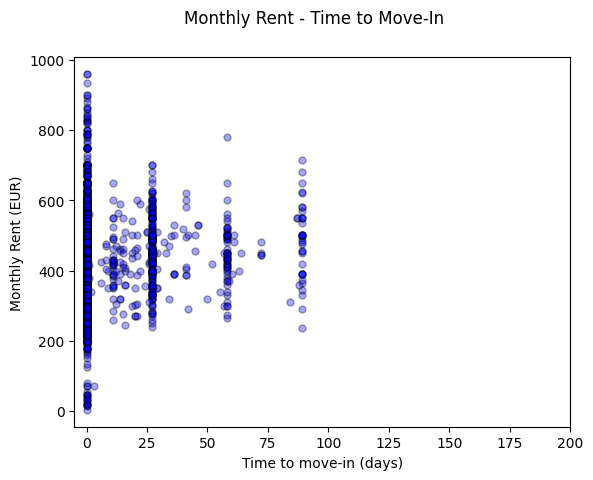

PearsonRResult(statistic=0.11215836941281562, pvalue=2.700723434339301e-29)

In [104]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.suptitle("Monthly Rent - Time to Move-In")
plt.xlabel('Time to move-in (days)')
plt.ylabel('Monthly Rent (EUR)')
plt.xlim(-5, 200)

plt.scatter(timeToMoveIn, rentPrice, s=25, c='blue',edgecolors='black', linewidths=1, alpha=0.35)
plt.show()

stats.pearsonr(timeToMoveIn, rentPrice)

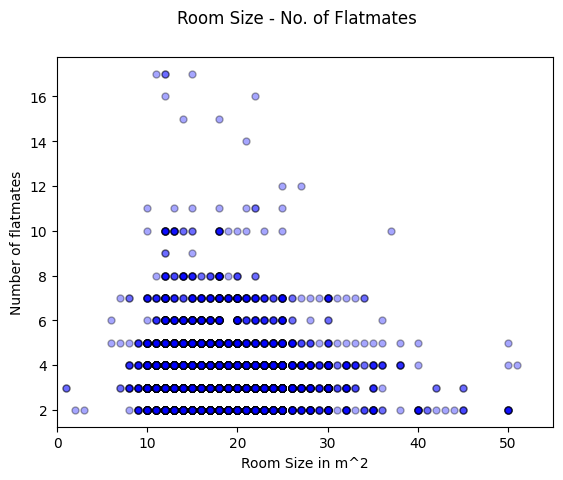

PearsonRResult(statistic=-0.032635857918325205, pvalue=0.0011136232081171563)

In [105]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.suptitle("Room Size - No. of Flatmates")
plt.ylabel('Number of flatmates')
plt.xlabel('Room Size in m^2')
plt.xlim(0, 55)

plt.scatter(roomSize, flatmates, s=25, c='blue',edgecolors='black', linewidths=1, alpha=0.35)
plt.show()

stats.pearsonr(roomSize, flatmates)

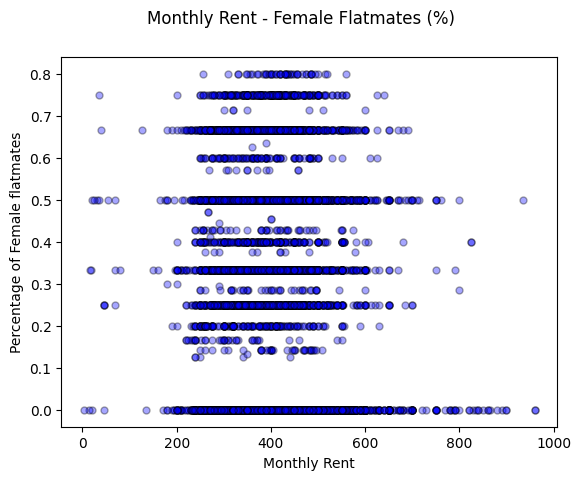

PearsonRResult(statistic=-0.08966876154801054, pvalue=2.883712079495222e-19)

In [106]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.suptitle("Monthly Rent - Female Flatmates (%)")
plt.ylabel('Percentage of Female flatmates')
plt.xlabel('Monthly Rent')

plt.scatter(rentPrice, femalePercentage, s=25, c='blue',edgecolors='black', linewidths=1, alpha=0.35)
plt.show()

stats.pearsonr(rentPrice, femalePercentage)

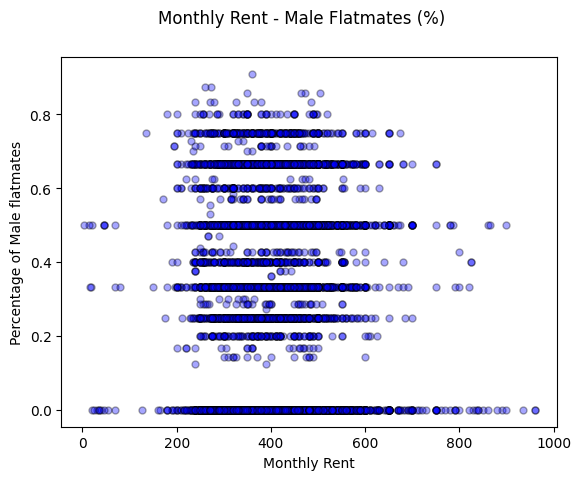

PearsonRResult(statistic=-0.05086587629900997, pvalue=3.7125780182093774e-07)

In [107]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.suptitle("Monthly Rent - Male Flatmates (%)")
plt.ylabel('Percentage of Male flatmates')
plt.xlabel('Monthly Rent')

plt.scatter(rentPrice, malePercentage, s=25, c='blue',edgecolors='black', linewidths=1, alpha=0.35)
plt.show()

stats.pearsonr(rentPrice, malePercentage)